# FinBERT and Lexicon for New York Times, US News, Analyst News

In [1]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')

model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Sentiment Analysis Example Using FinBERT

In [3]:
def predict_sentiment(text):
    tokens = tokenizer.encode_plus(text, add_special_tokens=False)
    
    if len(tokens['input_ids']) == 0:
        # Edge case, if no tokens, return probabilities with neutral probability=1
        return [0, 0, 1]
    
    # Maximum length of 510
    maximum_length = 510
    input_ids = tokens['input_ids'][:maximum_length]
    attention_mask = tokens['attention_mask'][:maximum_length]

    # 2 => Append [CLS] and [SEP], these are unique identifiers
    input_ids_chunk = [101] + input_ids + [102]
    attention_mask_chunk = [1] + attention_mask + [1]

    input_dict = {
        'input_ids' : torch.Tensor([input_ids_chunk]).long(),
        'attention_mask' : torch.Tensor([attention_mask_chunk]).int()
    }
    
    outputs = model(**input_dict)
    probabilities = torch.nn.functional.softmax(outputs[0], dim = -1)
    return probabilities.detach().numpy()[0]

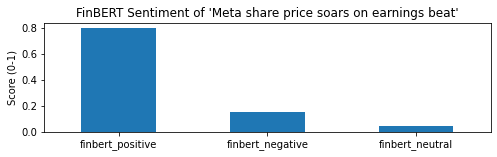

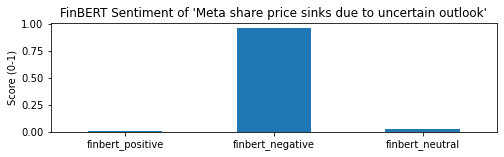

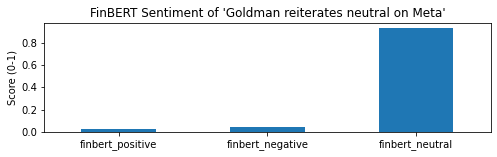

In [4]:
test_list = ["Meta share price soars on earnings beat", 
             "Meta share price sinks due to uncertain outlook", 
             "Goldman reiterates neutral on Meta"]

for txt in test_list:
    probabilities = predict_sentiment(txt)
    
    plt.figure(figsize=(8,2))
    pd.Series(probabilities, index=["finbert_positive", "finbert_negative", "finbert_neutral"]).plot(kind="bar")
    plt.xticks(rotation=0)
    plt.title(f"FinBERT Sentiment of '{txt}'")
    plt.ylabel("Score (0-1)")

# Lexicon Method of Feature Extraction

In [5]:
# If a word is considered a certain type (positive, negative etc)
# The row will contain the year that it was added into the dictionary
# So we use > 0 to get all the words
loughran_macdonald = pd.read_csv("../data/Loughran-McDonald_MasterDictionary_1993-2021.csv")
negative_words = set(loughran_macdonald.loc[loughran_macdonald.Negative > 0, "Word"].str.lower().values)
positive_words = set(loughran_macdonald.loc[loughran_macdonald.Positive > 0, "Word"].str.lower().values)
uncertain_words = set(loughran_macdonald.loc[loughran_macdonald.Uncertainty > 0, "Word"].str.lower().values)
litigious_words = set(loughran_macdonald.loc[loughran_macdonald.Litigious > 0, "Word"].str.lower().values)
strong_modal_words = set(loughran_macdonald.loc[loughran_macdonald.Strong_Modal > 0, "Word"].str.lower().values)
weak_modal_words = set(loughran_macdonald.loc[loughran_macdonald.Weak_Modal > 0, "Word"].str.lower().values)

In [6]:
# Helper function to find word counts
def find_word_count(text, dictionary):
    text = text.split(" ")
    count = 0
    for word in text:
        if word in dictionary:
            count += 1
    return count

def get_all_word_counts(df, text_col_name):
    
    negative_words_count = df[text_col_name].str.lower().apply(lambda text: find_word_count(text, negative_words))
    df["lmd_negative_words_count"] = negative_words_count
    
    positive_words_count = df[text_col_name].str.lower().apply(lambda text: find_word_count(text, positive_words))
    df["lmd_positive_words_count"] = positive_words_count
    
    uncertain_words_count = df[text_col_name].str.lower().apply(lambda text: find_word_count(text, uncertain_words))
    df["lmd_uncertain_words_count"] = uncertain_words_count
    
    litigious_words_count = df[text_col_name].str.lower().apply(lambda text: find_word_count(text, litigious_words))
    df["lmd_litigious_words_count"] = litigious_words_count
    
    strong_modal_words_count = df[text_col_name].str.lower().apply(lambda text: find_word_count(text, strong_modal_words))
    df["lmd_strong_modal_words_count"] = strong_modal_words_count
    
    weak_modal_words_count = df[text_col_name].str.lower().apply(lambda text: find_word_count(text, weak_modal_words))
    df["lmd_weak_modal_words_count"] = weak_modal_words_count
    
    return df

In [7]:
find_word_count("Meta has come under fire due to lawsuits", litigious_words)

1

# New York Times

In [10]:
from tqdm.notebook import tqdm
from pathlib import Path

from pynytimes import NYTAPI
import numpy as np
import pandas as pd

nyt_query_helper = pd.read_csv("../data/nyt_query_helper.csv")
nyt_query_helper.head()

for i in tqdm(range(len(nyt_query_helper))):
    row = nyt_query_helper.iloc[i]
    ticker = row["Symbol"]
    path = Path(f"../data/new_york_times/company/{ticker}.csv")
    new_save_path = Path(f"../data/new_york_times/company_processed/{ticker}.csv")
    
    curr_df = pd.read_csv(path)
    
    if len(curr_df) == 0:
        curr_df.to_csv(new_save_path, index=False)
        continue
        
    curr_df = curr_df.drop(columns="Unnamed: 0")
    
    # Headline is json, evaluate and get the main headline
    curr_df["main_headline"] = curr_df["headline"].apply(lambda x:eval(x)["main"])
    
    # Get finbert sentiment using pre defined sentiment
    finbert_sentiment = curr_df.main_headline.apply(lambda x: predict_sentiment(x)).values
    finbert_sentiment = pd.DataFrame(list(list(x) for x in finbert_sentiment))
    finbert_sentiment.columns = ["finbert_positive", "finbert_negative", "finbert_neutral"]
    
    curr_df = pd.concat([curr_df, finbert_sentiment],axis=1)
    
    curr_df = get_all_word_counts(curr_df, "main_headline")
    # Lastly, save
    curr_df.to_csv(new_save_path, index=False)

  0%|          | 0/736 [00:00<?, ?it/s]

# US News

In [13]:
us_equities_news_dataset = pd.read_csv("../data/other_news/us_equities_news_dataset.csv")
us_equities_news_dataset = get_all_word_counts(us_equities_news_dataset, "title")
finbert_sentiment = us_equities_news_dataset.title.apply(lambda x: predict_sentiment(x)).values
finbert_sentiment = pd.DataFrame(list(list(x) for x in finbert_sentiment))
finbert_sentiment.columns = ["finbert_positive", "finbert_negative", "finbert_neutral"]
us_equities_news_dataset = pd.concat([us_equities_news_dataset, finbert_sentiment],axis=1)
us_equities_news_dataset.to_csv("../data/other_news/us_equities_news_dataset_processed.csv", index=False)

# Analyst Ratings

In [15]:
analyst_ratings_processed = pd.read_csv("../data/other_news/analyst_ratings_processed.csv")

In [16]:
required_tickers = set(list(nyt_query_helper.Symbol.unique()) + list(nyt_query_helper.new_ticker.unique()))

In [18]:
from tqdm.notebook import tqdm
from pathlib import Path
import glob
import pandas as pd

for stock in tqdm(analyst_ratings_processed[analyst_ratings_processed.stock.notna()].stock.unique()):
    continue
    if stock not in required_tickers:
        continue
    print(stock)
    curr_df = analyst_ratings_processed[analyst_ratings_processed.stock == stock].copy().reset_index(drop=True)
    
    new_save_path = f"../data/other_news/analyst_ratings_processed/{stock}.csv"
    
    finbert_sentiment = curr_df.title.progress_apply(lambda x: predict_sentiment(x)).values
    finbert_sentiment = pd.DataFrame(list(list(x) for x in finbert_sentiment))
    finbert_sentiment.columns = ["finbert_positive", "finbert_negative", "finbert_neutral"]
    curr_df = pd.concat([curr_df, finbert_sentiment],axis=1)
    curr_df = get_all_word_counts(curr_df, "title")
    curr_df.to_csv(new_save_path, index=False)
    

# Now combine all into one large dataframe
all_other_news = []

for path in glob.glob("../data/other_news/analyst_ratings_processed/*"):
    continue
    ticker = path.replace(".csv", "").replace("../data/other_news/analyst_ratings_processed\\", "")
    curr_df = pd.read_csv(path).drop(columns=["title", "Unnamed: 0"]).rename(columns={"date":"date", "stock":"ticker"})
    all_other_news.append(curr_df)
    
all_analyst_ratings = pd.concat(all_other_news)
all_analyst_ratings.to_csv("../data/other_news_processed/analyst_ratings_processed.csv", index=False)

  0%|          | 0/6192 [00:00<?, ?it/s]